## 자동 미분과 그래디언트 테이프
### 그래디언트 테이프
- 텐서플로우는 자동미분을 위한 tf.GradientTape API를 제공
- tf.GradientTape는 컨텍스트 안에서 실행된 모든 연산을 테이프에 기록
- 후진 방식 자동 미분(reverse mode differetiation)을 사용하여 테이프에 기록된 연산 그레이언트를 계산

In [1]:
import tensorflow as tf

tf.__version__

'2.7.0'

In [4]:
x = tf.ones((2, 2))

with tf.GradientTape() as t:
  t.watch(x)
  y = tf.reduce_sum(x)
  print('y: ',y)
  z = tf.multiply(y, y)
  print('z: ',z)

# 입력 텐서 x에 대한 z의 도함수
dz_dx = t.gradient(z, x)
print(dz_dx)
for i in [0, 1]:
  for j in [0, 1]:
    # Assertion error가 발생하지 않음
    assert dz_dx[i][j].numpy() == 8.0

y:  tf.Tensor(4.0, shape=(), dtype=float32)
z:  tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(
[[8. 8.]
 [8. 8.]], shape=(2, 2), dtype=float32)


In [5]:
x = tf.ones((2, 2))

with tf.GradientTape() as t:
  t.watch(x)
  y = tf.reduce_sum(x)
  z = tf.multiply(y, y)

# tf.GradientTape() 안에서 계산된 중간 값에 대한 그래디언트도 구할 수 있다.
# 테이프를 사용하여 중간값 y에 대한 도함수를 계산

dz_dy = t.gradient(z, y) # GradientTape에 포함된 모든 리소스 해제
assert dz_dy.numpy() == 8.0

- GradientTape.gradient() 메소드가 호출되면 GradientTape에 포함된 모든 리소스가 해제된다.
- 동일한 연산에 대해 여러 그래디언트를 계산하려면 지속성 있는(persistent=True)그래디언트 테이프를 생성하면 된다.
- 이렇게 생성한 그래디언트 테이프를 gradient() 메소드의 다중 호출을 허용

In [10]:
x = tf.constant(3.0)

with tf.GradientTape(persistent=True) as t:
  t.watch(x)
  y = x * x
  z = y * y # z = x ^ 4

dz_dx = t.gradient(z, x) # GradientTape의 persistent=True로 설정했기 때문에 GradientTape의 리소스가 해제되지 않음
print(dz_dx)
dy_dx = t.gradient(y, x) 
print(dy_dx)

del t # 테이프에 대한 참조를 해제한다.

tf.Tensor(108.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


### 제어 흐름 기록
- 연산이 실행되는 순서대로 테이프에 기록되기 때문에 python 제어흐름이 자연스럽게 처리된다.

In [12]:
def f(x, y):
  output = 1.0
  for i in range(y):
    if i>1 and i<5:
      output = tf.multiply(output, x)
  return output

def grad(x, y):
  with tf.GradientTape() as t:
    t.watch(x)
    out = f(x, y)
  return t.gradient(out, x)

x = tf.convert_to_tensor(2.0)

print(grad(x, 6).numpy())
print(grad(x, 5).numpy())
print(grad(x, 4).numpy())

12.0
12.0
4.0


### 고계도(Higher-order) 그래디언트
- GradientTape 컨텍스트 매니저 안에 있는 연산들은 자동미분을 위해 기록된다.
- 만약 이 컨텍스트 안에서 그래디언트를 계산하면 해당 그래디언트 연산 또한 기록된다.

In [18]:
x = tf.Variable(1.0)

with tf.GradientTape() as t1:
  with tf.GradientTape() as t2:
    y = x * x * x
    # t1은 컨텍스트 매니저 안의 그래디언트를 계산
    # 이것은 또한 그래디언트 연산 자체도 미분이 가능하다는 것을 의미한다.
    dy_dx = t2.gradient(y, x) # dy_dx = 3 * x^2 at x = 1
dy2_dx2 = t1.gradient(dy_dx, x) # dy2_dx2 = 6 * x at x = 1

assert dy_dx.numpy() == 3.0
assert dy2_dx2.numpy() == 6.0

## ANN(Artificial Neural Network)

### Sequential 모델을 사용하는 경우
- sequential 모델은 각 레이어에 정확히 하나의 입력 텐서와 하나의 출력 텐서가 있는 일반 레이어 스택에 적합

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
      layers.Dense(2, activation='relu', name='layer1'), ## Pytorch - nn.Linear 
      layers.Dense(3, activation='relu', name='layer2'),
      layers.Dense(4, name='layer3'),
    ]
)
# Call model on a test input
x = tf.ones((3, 3))
# [1, 1, 1] -> [o, o] -> [o, o, o] -> [o, o, o, o]
y = model(x)
print(y)

tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]], shape=(3, 4), dtype=float32)


In [4]:
# Create 3 layers 
# 위의 함수와 동일
layer1 = layers.Dense(2, activation='relu', name='layer1')
layer2 = layers.Dense(3, activation='relu', name='layer2')
layer3 = layers.Dense(4, name='layer3')

# Call layers on a test input
x = tf.ones((3, 3))
y = layer3(layer2(layer1(x)))
print(y)

tf.Tensor(
[[-0.6741732  -0.46793675  0.7200943  -0.7732981 ]
 [-0.6741732  -0.46793675  0.7200943  -0.7732981 ]
 [-0.6741732  -0.46793675  0.7200943  -0.7732981 ]], shape=(3, 4), dtype=float32)


In [5]:
# layers 속성을 사용하여 레이어에 대해 접근할 수 있다.
model.layers

In [10]:
# add() 메서드를 통하여 Sequential 모델을 점진적으로 작성할 수 있다.
model = keras.Sequential()
model.add(layers.Dense(2, activation='relu'))
model.add(layers.Dense(3, activation='relu'))
model.add(layers.Dense(4))

In [11]:
model.layers

In [12]:
# pop 메서드를 사용하면 레이어를 제거할 수 있다.
model.pop()
model.layers

## 패션 MNIST 데이터를 사용한 분류 문제 

In [43]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [57]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels) ,(test_images, test_labels) = fashion_mnist.load_data()

In [58]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt','Sneaker', 'Bag', 'Ankle boot']

In [59]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [60]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

### 데이터 전처리

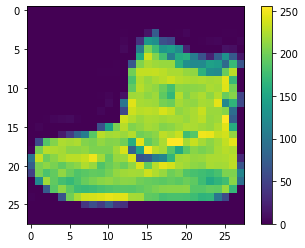

In [48]:
# 훈련 데이터셋의 첫번째 이미지
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [49]:
# 신경망 모델에 값을 주입하기 전에 값의 범위를 0~1로 조정
trian_images = train_images / 255.0

test_images = test_images / 255.0

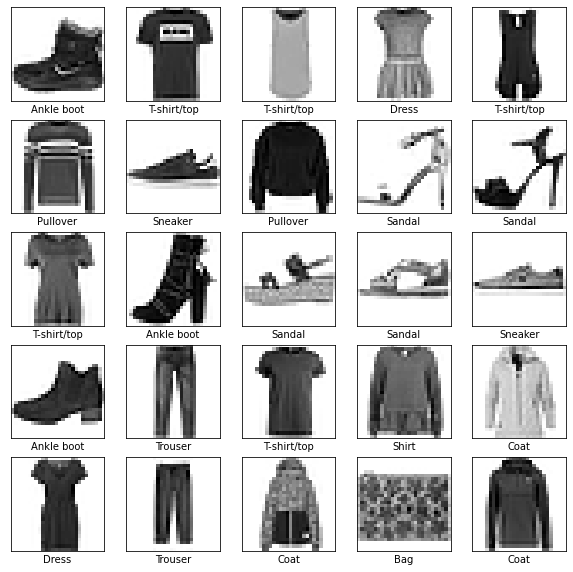

In [50]:
plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[i]])
  
plt.show()

### 모델 구성

In [61]:
model = keras.Sequential(
    [
      keras.layers.Flatten(input_shape=(28, 28)),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(10, activation='softmax'),
    ]
)

In [62]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               100480    
                                                                 
 dense_11 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


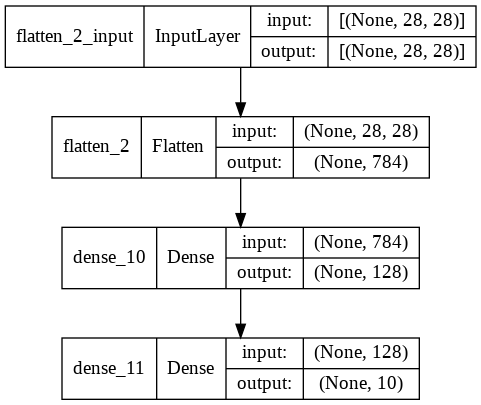

In [63]:
keras.utils.plot_model(model, show_shapes=True)

In [64]:
model.compile(optimizer='adam', # SGD, SGD + momentum
              loss='sparse_categorical_crossentropy', # 예측값이 특정한 정수값으로 나오는 경우 사용
              metrics=['accuracy'])

In [65]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 2.4269 - accuracy: 0.6856
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6846 - accuracy: 0.7437
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5863 - accuracy: 0.7841
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5320 - accuracy: 0.8103
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5153 - accuracy: 0.8187


In [66]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

print('Test loss:',test_loss)
print('Test accuracy: ', test_acc)

313/313 - 1s - loss: 0.6535 - accuracy: 0.7903 - 591ms/epoch - 2ms/step
Test loss: 0.6534611582756042
Test accuracy:  0.7903000116348267


In [67]:
# 훈련된 모델을 사용하여 이미지에 대한 예측 만들기
predictions = model.predict(test_images) 

In [68]:
# 10개의 옷 품목에 상응하는 모델의 신뢰도(confidence)를 나타냄
predictions[0]

array([3.5246053e-22, 5.0368872e-25, 0.0000000e+00, 1.7243488e-20,
       5.4728981e-31, 1.0868925e-01, 6.4135809e-27, 1.3495304e-02,
       5.8927094e-09, 8.7781543e-01], dtype=float32)

In [71]:
# 가장 높은 신뢰도를 가진 레이블 출력
np.argmax(predictions[0])

9

In [72]:
# 실제 테스트 데이터의 0번째 값
test_labels[0]

9

In [73]:
# 10개의 클래스에 대한 예측을 모두 그래프로 표현
# 올바르게 예측된 레이블은 파란색으로, 잘못 예측된 레이블은 빨간색으로 표현
# 숫자는 예측 레이블의 신뢰도

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color='blue'
  else:
    color='red'
  
  plt.xlabel('{} {:2.0f}% {{}}'.format(class_names[predicted_label], 100*np.max(predictions_array), class_names[true_label], color=color))

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color='#777777')
  plt.ylim([0,1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


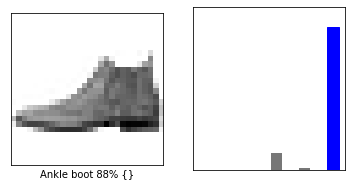

In [75]:
# 0번째 원소의 이미지, 예측, 신뢰도 점수 배열

i=0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)
plt.show()

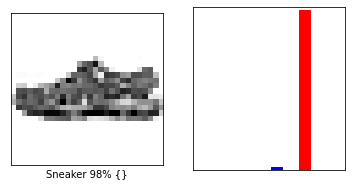

In [95]:
i = 21
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)
plt.show()